In [31]:
# Step 3: Define URLs for the four coordinated users
user_to_url = {
    f"coordinated_user_0": "https://x.com/federico_cinus?lang=en",
    f"coordinated_user_1": "https://x.com/fractalzucky",
    f"coordinated_user_2": "https://x.com/emilio__ferrara",
    f"coordinated_user_3": "https://x.com/LucaLuceri"
}

# 0. Random data generation process

In [81]:
import numpy as np
import os

os.makedirs("../data", exist_ok=True)

# Parameters definition
NUMBER_OF_ROWS = 1_000
NUMBER_OF_USERS = 100
NUMBER_OF_URLS = 100_000

data = {
    "user": [f"user_{np.random.randint(0, NUMBER_OF_USERS)}" for _ in range(NUMBER_OF_ROWS)],
    "url": [f"http://example.com/{np.random.randint(0, NUMBER_OF_URLS)}" for _ in range(NUMBER_OF_ROWS)],
    "value": np.random.rand(NUMBER_OF_ROWS)
}

------

# 1. Dataset format

### Suggestion: Use parquet: https://en.wikipedia.org/wiki/Apache_Parquet

### Facts:

In [82]:
import polars as pl
from pathlib import Path
import os

# Convert to polars table
df_random_table = pl.DataFrame(data)

# File paths
parquet_file = Path("../data/dataset.parquet")
csv_file = Path("../data/dataset.csv")

# Write to Parquet
df_random_table.write_parquet(parquet_file)

# Write to CSV
df_random_table.write_csv(csv_file)

# Get file sizes
parquet_size = os.path.getsize(parquet_file)
csv_size = os.path.getsize(csv_file)

# Compare sizes
print(f"Parquet size: {parquet_size / 1024:,.1f} KB")
print(f"CSV size: {csv_size / 1024:,.1f} KB")

# Calculate the percentage difference
size_difference_percentage = ((csv_size - parquet_size) / csv_size) * 100

# Display the percentage difference
print(f"Size difference: {size_difference_percentage:.2f}% smaller for Parquet compared to CSV.")

Parquet size: 13.0 KB
CSV size: 50.9 KB
Size difference: 74.52% smaller for Parquet compared to CSV.


----

# 2. Data Processing

### Suggestion: use Polars: https://pola.rs/

### Polars

### Facts:

1. **Parallel Processing**: Polars is built in Rust and is designed to leverage multicore CPUs, allowing it to execute operations across multiple threads. This parallelism significantly speeds up tasks like filtering, aggregating, and transforming data compared to PyArrow or Pandas.

2. **Lazy Evaluation**: Polars supports lazy evaluation, which optimizes the execution plan by analyzing the entire query before running it. This ensures that operations are only executed when necessary, reducing redundant computations.

3. **Efficient Memory Management**: Polars uses a columnar storage format similar to Apache Arrow but optimizes data layout and memory access patterns for faster in-memory computations. This results in lower memory overhead and faster data access.

4. **Built-in Rust Optimizations**: Polars is written in Rust, which provides memory safety and low-level optimizations, giving Polars an edge in execution speed and resource management.

**Best for**: Fast in-memory data manipulation, especially on large datasets that fit in a single machine's memory.

**Strengths**: Highly efficient with parallel processing, lazy evaluation, and optimized for modern multicore CPUs.

**Use Case**: Data analytics pipelines with large datasets that require high performance, especially when running complex operations (e.g., group-by, joins).


In [83]:
import pandas as pd
import polars as pl
import numpy as np
import time
from functools import wraps

# Timing decorator
def time_it(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.4f} seconds")
        return result
    return wrapper

### 2.1 Loading

In [84]:
from pathlib import Path

# File paths
parquet_file = Path("../data/dataset.parquet")
csv_file = Path("../data/dataset.csv")

# Pandas loading tests
import pandas as pd
print("Pandas Load Times:")
%time pandas_df_csv = pd.read_csv(csv_file)
%time pandas_df_parquet = pd.read_parquet(parquet_file)

import polars as pl
# Polars loading tests
print("\nPolars Load Times:")
%time polars_df_csv = pl.read_csv(csv_file)
%time polars_df_parquet = pl.read_parquet(parquet_file)

import pyarrow.parquet as pq
import pyarrow.csv as pv
# PyArrow loading tests
print("\nPyArrow Load Times:")
%time pyarrow_df_csv = pv.read_csv(csv_file)
%time pyarrow_df_parquet = pq.read_table(parquet_file)
# PyArrow does not have an in-memory DataFrame structure

Pandas Load Times:
CPU times: user 1.36 ms, sys: 681 μs, total: 2.04 ms
Wall time: 2.06 ms
CPU times: user 1.73 ms, sys: 94 μs, total: 1.82 ms
Wall time: 1.79 ms

Polars Load Times:
CPU times: user 0 ns, sys: 463 μs, total: 463 μs
Wall time: 386 μs
CPU times: user 547 μs, sys: 0 ns, total: 547 μs
Wall time: 324 μs

PyArrow Load Times:
CPU times: user 480 μs, sys: 185 μs, total: 665 μs
Wall time: 414 μs
CPU times: user 662 μs, sys: 0 ns, total: 662 μs
Wall time: 499 μs


### 2.2 Loading larger files

In [70]:
# Larger dataframe ~10M rows

# File paths
csv_file_large = Path("../data/dataset-large.csv")
parquet_file_large = Path("../data/dataset-large.parquet")

# Pandas loading tests
print("Pandas Load Times:")
%time pandas_df_csv = pd.read_csv(csv_file_large)
%time pandas_df_parquet = pd.read_parquet(parquet_file_large)

# Polars loading tests
print("\nPolars Load Times:")
%time polars_df_csv = pl.read_csv(csv_file_large)
%time polars_df_parquet = pl.read_parquet(parquet_file_large)
%time polars_df_memory = pl.DataFrame(data)

# PyArrow loading tests
print("\nPyArrow Load Times:")
%time pyarrow_df_csv = pv.read_csv(csv_file_large)
%time pyarrow_df_parquet = pq.read_table(parquet_file_large)
# PyArrow does not have an in-memory DataFrame structure

Pandas Load Times:
CPU times: user 2.59 s, sys: 130 ms, total: 2.72 s
Wall time: 2.72 s
CPU times: user 690 ms, sys: 122 ms, total: 812 ms
Wall time: 420 ms

Polars Load Times:
CPU times: user 813 ms, sys: 156 ms, total: 969 ms
Wall time: 209 ms
CPU times: user 136 ms, sys: 65.2 ms, total: 201 ms
Wall time: 45.4 ms
CPU times: user 859 ms, sys: 58 ms, total: 917 ms
Wall time: 897 ms

PyArrow Load Times:
CPU times: user 827 ms, sys: 224 ms, total: 1.05 s
Wall time: 252 ms
CPU times: user 401 ms, sys: 72.3 ms, total: 473 ms
Wall time: 121 ms


### 2.2.1 Other libraries to mention: 

https://medium.com/@nandeda.narayan/data-processing-at-scale-comparison-of-pandas-polars-and-dask-333ae65c0a45

https://www.confessionsofadataguy.com/pyarrow-vs-polars-vs-duckdb-for-data-pipelines/

In [85]:
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

PyArrow:

1. Data Storage and I/O: Efficiently read/write Parquet and Feather files, with support for compression and partitioning.
    
2. Interoperability: Exchange data seamlessly between different libraries (e.g., Pandas, Spark) and languages (e.g., Python, R).

3. In-Memory Data Sharing: Use Arrow IPC for zero-copy, high-performance data sharing between processes.
                                        
4. Schema Management: Manage evolving data structures and metadata, making it easy to track and adapt to changes.
                                        
5. Single-Machine Optimizations: Ideal for single-machine use cases with fast, columnar data access but without parallel processing.


Dask:

1. Parallel and Distributed Processing: Perform computations on large datasets across multiple cores or even a cluster.

2. Scalable Pandas-Like Interface: Use Dask DataFrames for familiar Pandas-like syntax, scaling to datasets that exceed memory.
    
3. Out-of-Core Processing: Handle data that doesn’t fit into RAM by processing it in chunks from disk.
    
4. Complex Workflows and Pipelines: Build complex workflows with delayed computation, optimized scheduling, and fault tolerance.
    
5. Big Data Integration: Integrate with distributed storage systems (e.g., S3, HDFS) and big data libraries like Dask ML for scalable machine learning.

### 2.3 Processing

In [86]:
# Pandas operations with timing
@time_it
def pandas_unique_urls_above_threshold(data: pd.DataFrame, threshold: float) -> int:
    '''Filtering and extracting numeric portion of URLs
    '''
    df_pandas["url_number"] = df_pandas["url"].str.extract(r'(\d+)$').astype(int)
    df_filtered = df_pandas[df_pandas["url_number"] > threshold]
    unique_urls = df_filtered["url"].nunique()
    return unique_urls

# Polars operations with timing
@time_it
def polars_unique_urls_above_threshold(data: pl.DataFrame, threshold: float) -> int:
    # Filtering, extracting, and counting unique URLs in a chained operation
    unique_urls = (
        df_polars
        .with_columns(pl.col("url").str.extract(r'(\d+)$').cast(pl.Int32).alias("url_number"))
        .filter(pl.col("url_number") > threshold)
        .select(pl.col("url").n_unique())
        .item()  # To get the single resulting value
    )
    return unique_urls


# Cast dataframes
df_pandas = pd.DataFrame(data)
df_polars = pl.DataFrame(data)

threshold = NUMBER_OF_URLS // 2

In [87]:
# Run and compare
print("Running Pandas unique URL count:")
pandas_result = pandas_unique_urls_above_threshold(df_pandas, threshold)
print(f"Unique URLs in Pandas: {pandas_result}")

print("\nRunning Polars unique URL count:")
polars_result = polars_unique_urls_above_threshold(df_polars, threshold)
print(f"Unique URLs in Polars: {polars_result}")

Running Pandas unique URL count:
pandas_unique_urls_above_threshold took 0.0024 seconds
Unique URLs in Pandas: 500

Running Polars unique URL count:
polars_unique_urls_above_threshold took 0.0008 seconds
Unique URLs in Polars: 500


### Notes

ChatGPT 4 is not updated --> Look at Polars' documentation: https://docs.pola.rs/

1. apply --> map_elements
2. groupby --> group_by
3. nunique --> n_unique

Lazy execution does not allow progress_apply()

-----

# 3. Coordination Detection

### Suggestion: use cuML if you want fast execution and your data fits in the GPU: https://docs.rapids.ai/api/cuml/stable/

### Facts:

1. **GPU-Accelerated**: cuML is built on CUDA and is optimized for GPU acceleration, allowing it to perform data processing and machine learning computations much faster than CPU-based libraries, especially on large datasets.

2. **Scalable Algorithms**: cuML provides scalable implementations of essential machine learning algorithms, including clustering, linear regression, and nearest neighbors. These algorithms are designed to handle large datasets efficiently on GPU hardware.

3. **Interoperability with RAPIDS Ecosystem**: cuML is part of the RAPIDS AI ecosystem, which includes libraries like cuDF (a GPU DataFrame library). This compatibility enables end-to-end GPU-accelerated workflows, allowing data to stay on the GPU from preprocessing to model training.

4. **Pythonic API with Scikit-Learn Compatibility**: cuML's API closely resembles that of Scikit-Learn, making it easy for users to transition existing codebases or pipelines to GPU-accelerated workflows with minimal code changes.

**Best for**: Fast, GPU-accelerated machine learning on large datasets that fit in GPU memory.

**Strengths**: High-speed computations with GPU acceleration, easy integration with the RAPIDS ecosystem, and compatibility with Scikit-Learn syntax.

**Use Case**: Machine learning tasks that benefit from GPU speedups, such as clustering, nearest neighbor search, and linear regression, on datasets with thousands to millions of entries, when training on a single GPU is feasible.


In [88]:
import polars as pl
import cudf
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.metrics import pairwise_distances
import cupy as cp  # Used for GPU operations

# Check if GPU is available
if cp.cuda.runtime.getDeviceCount() > 0:
    print("GPU is available and will be used.")
else:
    raise SystemError("GPU is not available. Please ensure that a CUDA-compatible GPU is set up.")


GPU is available and will be used.


In [89]:
from scipy.sparse import csr_matrix

# Polars DataFrame grouping and transformation
df_polars_grouped = df_polars.group_by('user').agg(pl.col('url').str.concat(' '))

# Fake coordinated accounts
# --- Define four coordinated users connected to all URLs
coordinated_users = [f"coordinated_user_{i}" for i in range(4)]
all_urls_string = " ".join([f"http://example.com/{i}" for i in range(NUMBER_OF_URLS)])

# ---- Concatenate the coordinated users to the grouped DataFrame
coordinated_users_df = pl.DataFrame({
    "user": coordinated_users,
    "url": [all_urls_string] * len(coordinated_users)
})
df_polars_grouped = pl.concat([df_polars_grouped, coordinated_users_df])

# Convert grouped Polars DataFrame to cuDF
df_cudf = cudf.DataFrame.from_pandas(df_polars_grouped.to_pandas())

# Step 1: TF-IDF Vectorization on the 'url' column
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_cudf['url'])

# Step 2: Compute Cosine Similarity Matrix
# Cosine similarity can be derived as (1 - cosine distance)
cosine_similarity_matrix = 1 - pairwise_distances(tfidf_matrix, metric="cosine")

# Step 3: Convert to CSR matrix format and set diagonal to 0
sparse_matrix_csr = csr_matrix(cosine_similarity_matrix.get())  # Move from GPU to CPU
sparse_matrix_csr.setdiag(0)  # Removing self-loops

# The result is a sparse matrix ready for further processing
sparse_matrix_csr

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 10816 stored elements and shape (104, 104)>

### Notes:

Choosing Between FAISS, cuML, and Sklearn for Pairwise Distance Computation

1. **FAISS**
   - **Best for**: Large-scale, dense vector search (high-dimensional data).
   - **Strengths**: Optimized for Approximate Nearest Neighbor (ANN) search, scalable to multi-GPU or distributed setups.
   - **Use Case**: Real-time, large-scale recommendation systems or retrieval tasks with millions of entries.

2. **cuML**
   - **Best for**: Fast, exact similarity computation on datasets within single GPU memory.
   - **Strengths**: GPU-accelerated, efficient for moderately sized datasets.
   - **Use Case**: Exact user-to-user similarity or distance computations with thousands to tens of thousands of entries.

3. **Sklearn**
   - **Best for**: CPU-based exact computation on smaller or distributed datasets.
   - **Strengths**: Accessible in CPU-only environments, good for modest data sizes.
   - **Use Case**: Smaller datasets or CPU-only batch processing, where GPU memory is insufficient.

------

# 4. Interactive visualization

### Suggestion: use PyViz: https://pyviz.org/

### Facts:

1. **Interactive Visualizations**: PyViz provides tools for creating interactive visualizations that allow users to explore complex datasets directly within Jupyter Notebooks or standalone dashboards.

2. **Integration with Popular Libraries**: PyViz integrates seamlessly with popular Python visualization libraries, such as Matplotlib, Bokeh, and Plotly, making it adaptable for various plotting needs and compatible with existing codebases.

3. **Scalable for Large Datasets**: PyViz is designed to handle large datasets efficiently, with support for data streaming and dynamic updates, making it ideal for real-time data visualization in big data and IoT applications.

4. **High-Level Interface with HoloViews**: PyViz includes HoloViews, which simplifies creating complex visualizations by allowing users to define visual representations directly from their data without extensive plotting code.

**Best for**: Creating interactive and scalable visualizations in Jupyter Notebooks or dashboards.

**Strengths**: Flexibility to handle large datasets, seamless integration with popular libraries, and high-level interfaces for intuitive plotting.

**Use Case**: Exploratory data analysis, real-time monitoring dashboards, and visualizing complex data structures interactively in Jupyter or web applications.


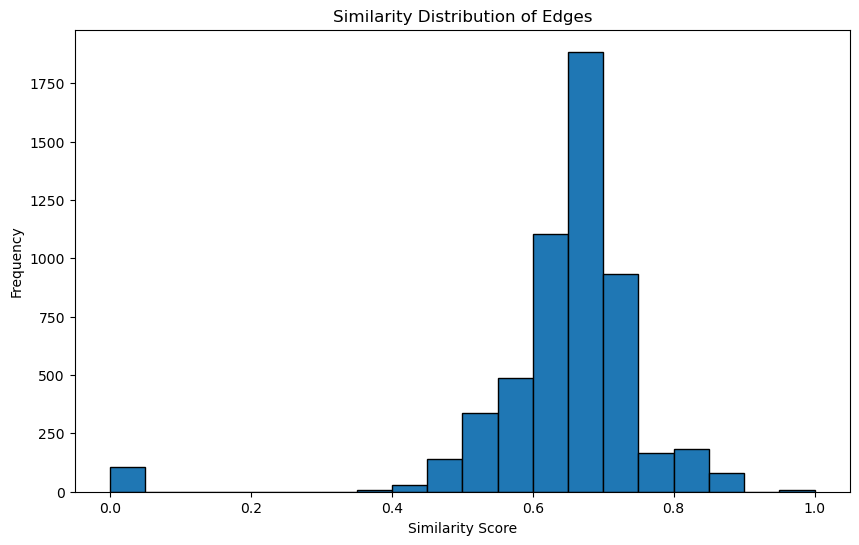

In [95]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt

# Step 1: Create Graph from Similarity Matrix
G = nx.from_scipy_sparse_array(sparse_matrix_csr, create_using=nx.Graph)
usernames = df_polars_grouped['user'].to_list()
G = nx.relabel_nodes(G, dict(enumerate(usernames)))  # Map integer indices to actual usernames

# Step 2: Plot Similarity Distribution
similarities = [d['weight'] for _, _, d in G.edges(data=True)]

plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=20, edgecolor='black')
plt.title("Similarity Distribution of Edges")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

In [96]:
# Step 3: Filter edges based on minimum similarity threshold
min_similarity = 0.95
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= min_similarity]
G.remove_edges_from(edges_to_remove)
G.remove_nodes_from(list(nx.isolates(G)))  # Remove disconnected nodes

# Step 4: Add clickable link to each node
for user in G.nodes:
    # Get the user's specific URL or a default URL format
    url = user_to_url.get(user, f"https://x.com/user-{user}")
    G.nodes[user]["title"] = f"<a href='{url}' target='_blank'>Click to view profile</a>"


# Step 5: Visualize with PyViz
net = Network(notebook=True)
net.from_nx(G)
net.show("similarity_graph.html")

similarity_graph.html
